Welcome to XGboost electirc bogaloo, most of the code is coppied and pasted form either NOTES or RANDOMFOREST

In [ ]:
# Import lib
import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from xgboost import XGBRegressor

# Import data, X and y for training
X_all_lf = pd.read_csv("data/forecast_data_lf.csv")
y_all = pd.read_csv("data/target_train.csv")

## Split into training and testing, solar and wind

In [75]:
#print(X_all_lf.shape) # (54336, 14)
#print(y_all.shape) # (54336, 5)
#display(X_all_lf)
#display(y_all)

from sklearn.model_selection import train_test_split

# Split into solar and wind traning and test
solar_features = ["valid_datetime",
                "dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature", 
                "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature"]
wind_features = ["valid_datetime",
                "dwd_RelativeHumidity", "dwd_WindDirection_100", "dwd_WindSpeed_100", 
                "ncep_RelativeHumidity", "ncep_WindDirection_100", "ncep_WindSpeed_100"]

X_solar = X_all_lf[solar_features]
X_wind = X_all_lf[wind_features]

y_solar = y_all["Solar_MWh_credit"]
y_wind = y_all["Wind_MWh_credit"]

X_solar_train, X_solar_test, y_solar_train, y_solar_test = train_test_split(
    X_solar, y_solar, test_size=0.2, random_state=42, shuffle=False
)

X_wind_train, X_wind_test, y_wind_train, y_wind_test = train_test_split(
    X_wind, y_wind, test_size=0.2, random_state=42, shuffle=False
)



## Feature Engineering

In [ ]:
# Define functions 
def add_cyclic_time_features(df, dt_col="valid_datetime", drop_original=True):
    df = df.copy()
    df[dt_col] = pd.to_datetime(df[dt_col])

    df["hour_sin"] = np.sin(2*np.pi*(df[dt_col].dt.hour + df[dt_col].dt.minute/60)/24)
    df["hour_cos"] = np.cos(2*np.pi*(df[dt_col].dt.hour + df[dt_col].dt.minute/60)/24)
    df["weekday_sin"] = np.sin(2*np.pi*df[dt_col].dt.weekday/7)
    df["weekday_cos"] = np.cos(2*np.pi*df[dt_col].dt.weekday/7)
    df["month_sin"] = np.sin(2*np.pi*df[dt_col].dt.month/12)
    df["month_cos"] = np.cos(2*np.pi*df[dt_col].dt.month/12)

    if drop_original:
        df = df.drop(columns=dt_col)

    return df

def add_wind_direction_cyclic(df, wind_dir_columns, drop_original=True):
    df = df.copy()
    for col in wind_dir_columns:
        radians = np.deg2rad(df[col])
        df[f"{col}_sin"] = np.sin(radians)
        df[f"{col}_cos"] = np.cos(radians)
    
    if drop_original:
        df = df.drop(columns=wind_dir_columns)
    return df

def add_lag_features(df, columns, lags=[-2, -1, 0, 1, 2], drop_original=True):
    df = df.copy()
    
    for col in columns:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)

    if drop_original:
        df = df.drop(columns=columns)
    return df

def scale_features(df, scaler=None):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if scaler is None:
        scaler = MinMaxScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    else:
        df[numeric_cols] = scaler.transform(df[numeric_cols])

    return df, scaler

# affected col
wind_lag_col = ["dwd_RelativeHumidity", "dwd_WindSpeed_100", "ncep_RelativeHumidity", "ncep_WindSpeed_100"]
solar_lag_col = ["dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature",
                "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature",]

# call functions for wind
X_wind_train = add_cyclic_time_features(df=X_wind_train)
X_wind_train = add_wind_direction_cyclic(df=X_wind_train, wind_dir_columns=["dwd_WindDirection_100", "ncep_WindDirection_100"])
X_wind_train = add_lag_features(df=X_wind_train, columns=wind_lag_col)
X_wind_train, wind_scale = scale_features(df=X_wind_train, scaler=None)

print(X_wind_train.head(0))

X_wind_test = add_cyclic_time_features(X_wind_test)
X_wind_test = add_wind_direction_cyclic(df=X_wind_test, wind_dir_columns=["dwd_WindDirection_100", "ncep_WindDirection_100"])
X_wind_test = add_lag_features(df=X_wind_test, columns=wind_lag_col)
X_wind_test, _ = scale_features(df=X_wind_test, scaler=wind_scale)

print(X_wind_test.head(0))

X_solar_train = add_cyclic_time_features(df=X_solar_train)
X_solar_train = add_lag_features(df=X_solar_train, columns=solar_lag_col)
X_solar_train, solar_scale = scale_features(df=X_solar_train, scaler=None)

print(X_solar_train.head(0))

X_solar_test = add_cyclic_time_features(df=X_solar_test)
X_solar_test = add_lag_features(df=X_solar_test, columns=solar_lag_col)
X_solar_test, _ = scale_features(df=X_solar_test, scaler=solar_scale)

print(X_solar_test.head(0))

X_solar_train = X_solar_train.ffill().bfill()
X_solar_test = X_solar_test.ffill().bfill()
X_wind_train = X_wind_train.ffill().bfill()
X_wind_test = X_wind_test.ffill().bfill()

print(f"\nNumber of NaN values: {X_solar_train.isna().sum().sum() + X_solar_test.isna().sum().sum() + X_wind_train.isna().sum().sum() + X_wind_test.isna().sum().sum()}")

Empty DataFrame
Columns: [hour_sin, hour_cos, weekday_sin, weekday_cos, month_sin, month_cos, dwd_WindDirection_100_sin, dwd_WindDirection_100_cos, ncep_WindDirection_100_sin, ncep_WindDirection_100_cos, dwd_RelativeHumidity_lag-2, dwd_RelativeHumidity_lag-1, dwd_RelativeHumidity_lag0, dwd_RelativeHumidity_lag1, dwd_RelativeHumidity_lag2, dwd_WindSpeed_100_lag-2, dwd_WindSpeed_100_lag-1, dwd_WindSpeed_100_lag0, dwd_WindSpeed_100_lag1, dwd_WindSpeed_100_lag2, ncep_RelativeHumidity_lag-2, ncep_RelativeHumidity_lag-1, ncep_RelativeHumidity_lag0, ncep_RelativeHumidity_lag1, ncep_RelativeHumidity_lag2, ncep_WindSpeed_100_lag-2, ncep_WindSpeed_100_lag-1, ncep_WindSpeed_100_lag0, ncep_WindSpeed_100_lag1, ncep_WindSpeed_100_lag2]
Index: []

[0 rows x 30 columns]
Empty DataFrame
Columns: [hour_sin, hour_cos, weekday_sin, weekday_cos, month_sin, month_cos, dwd_WindDirection_100_sin, dwd_WindDirection_100_cos, ncep_WindDirection_100_sin, ncep_WindDirection_100_cos, dwd_RelativeHumidity_lag-2, dwd

Great, every feature is lined up, move on to modeling

In [ ]:
# Checking 
#print(X_solar_train.shape)
#print(X_solar_test.shape)
#print(y_solar_test.shape)
#print(y_solar_train.shape)
#print(X_wind_train.shape)
#print(X_wind_test.shape)
#print(y_wind_train.shape)
#print(y_wind_test.shape)

# Define scaling target function

# Define functions for quantiles
def pinball(y, q, alpha):
    return (y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q)

def pinball_score(df):
    scores = [
        pinball(
            y=df["total_generation_MWh"],
            q=df[f"q{qu}"],
            alpha=qu/100
        ).mean()
        for qu in range(10, 100, 10)
    ]
    return np.mean(scores)

# Define quantiles
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

solar_models = {q: XGBRegressor(objective="reg:quantileerror", quantile_alpha=q).fit(X_solar_train, y_solar_train) for q in quantiles}
solar_preds = {q: model.predict(X_solar_test) for q, model in solar_models.items()}

wind_models = {q: XGBRegressor(objective="reg:quantileerror", quantile_alpha=q).fit(X_wind_train, y_wind_train) for q in quantiles}
wind_preds = {q: model.predict(X_wind_test) for q, model in wind_models.items()}

df_preds = pd.DataFrame({
    "total_generation_MWh": y_solar_test + y_wind_test,
    "q10": solar_preds[0.1] + wind_preds[0.1],
    "q20": solar_preds[0.2] + wind_preds[0.2],
    "q30": solar_preds[0.3] + wind_preds[0.3],
    "q40": solar_preds[0.4] + wind_preds[0.4],
    "q50": solar_preds[0.5] + wind_preds[0.5],
    "q60": solar_preds[0.6] + wind_preds[0.6],
    "q70": solar_preds[0.7] + wind_preds[0.7],
    "q80": solar_preds[0.8] + wind_preds[0.8],
    "q90": solar_preds[0.9] + wind_preds[0.9],
})

scores = pinball_score(df_preds)
print(scores)

# Pinball score without Gridsearch: 27.715809955091
# typical run time seconds 

27.715809955091


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform

# Competition pinball functions
def pinball(y, q, alpha):
    return (y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q)

def pinball_score(df):
    scores = [
        pinball(df["total_generation_MWh"], df[f"q{qu}"], qu / 100).mean()
        for qu in range(10, 100, 10)
    ]
    return np.mean(scores)

# Custom pinball functions
def pinball_loss(y_true, y_pred, alpha):
    err = y_true - y_pred
    return np.mean(np.where(err >= 0, alpha * err, (1 - alpha) * -err))

def make_pinball_scorer(alpha):
    return make_scorer(pinball_loss, alpha=alpha, greater_is_better=False)

# Train models with search
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
solar_models = {}
wind_models = {}
solar_preds = {}
wind_preds = {}

solar_param_dist = {
    # Core parameters
    "n_estimators": randint(100, 600),
    "max_depth": randint(3, 8),
    "learning_rate": uniform(0.01, 0.2),  # Wider range but favoring lower rates
    "min_child_weight": randint(1, 6),
    
    # Stochastic parameters
    "subsample": uniform(0.6, 0.4),  # Range 0.6-1.0
    "colsample_bytree": uniform(0.6, 0.4),
    "colsample_bylevel": uniform(0.6, 0.4),
    
    # Regularization
    "gamma": uniform(0, 0.3),
    "reg_alpha": uniform(0, 2),
    "reg_lambda": uniform(0, 2),
    
    # Solar-specific
    "max_delta_step": randint(0, 2),
}

wind_param_dist = {
    # Core parameters
    "n_estimators": randint(200, 800),  # More trees for complex wind patterns
    "max_depth": randint(5, 10),  # Deeper trees
    "learning_rate": uniform(0.05, 0.3),  # Higher learning rates
    "min_child_weight": randint(1, 10),  # Stronger regularization
    
    # Stochastic parameters
    "subsample": uniform(0.5, 0.5),  # More aggressive subsampling
    "colsample_bytree": uniform(0.5, 0.5),
    "colsample_bynode": uniform(0.5, 0.5),  # Additional sampling level
    
    # Regularization
    "gamma": uniform(0.1, 0.5),  # Higher minimum loss reduction
    "reg_alpha": uniform(0.5, 5),
    "reg_lambda": uniform(0.5, 5),
    
    # Wind-specific
    "max_delta_step": randint(0, 5),  # Larger steps for volatile output
}

for q in quantiles:
    print(f"Training quantile {q}")

    # Solar
    base_model = XGBRegressor(objective="reg:quantileerror", quantile_alpha=q, random_state=42)
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=solar_param_dist,
        n_iter=50, 
        scoring=make_pinball_scorer(alpha=q),
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    random_search.fit(X_solar_train, y_solar_train)
    solar_models[q] = random_search.best_estimator_
    solar_preds[q] = random_search.best_estimator_.predict(X_solar_test)

    # Wind
    base_model = XGBRegressor(objective="reg:quantileerror", quantile_alpha=q, random_state=42)
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=wind_param_dist,
        n_iter=50, 
        scoring=make_pinball_scorer(alpha=q),
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    random_search.fit(X_wind_train, y_wind_train)
    wind_models[q] = random_search.best_estimator_
    wind_preds[q] = random_search.best_estimator_.predict(X_wind_test)

df_preds = pd.DataFrame({
    "total_generation_MWh": np.array(y_solar_test) + np.array(y_wind_test)
})

for q in quantiles:
    df_preds[f"q{int(q*100)}"] = solar_preds[q] + wind_preds[q]

final_score = pinball_score(df_preds)
print(f"\n FinalPinball Score: {final_score}")

# it took 75 min to get a new score of 27.38947

Training quantile 0.1
Training quantile 0.2
Training quantile 0.3
Training quantile 0.4
Training quantile 0.5
Training quantile 0.6
Training quantile 0.7
Training quantile 0.8
Training quantile 0.9

 FinalPinball Score: 27.38947


In [82]:
# prepross_comp mostly copied from RandomForest

start_date_comp = pd.Timestamp("2024-02-20 00:00:00+00:00")
end_date_comp = pd.Timestamp("2024-05-19 23:30:00+00:00")

energy_data_2 = pd.read_csv("data_comp/Energy_Data_20240119_20240519.csv")
energy_data_2["dtm"] = pd.to_datetime(energy_data_2["dtm"])

filtered_data = energy_data_2[
    (energy_data_2["dtm"] >= start_date_comp) &
    (energy_data_2["dtm"] <= end_date_comp)
].copy()

filtered_data["Wind_MWh_credit"] = 0.5*filtered_data["Wind_MW"] - filtered_data["boa_MWh"]
filtered_data["Solar_MWh_credit"] = 0.5*filtered_data["Solar_MW"]
filtered_data["total_generation_MWh"] = filtered_data["Wind_MWh_credit"] + filtered_data["Solar_MWh_credit"]

y_true_comp = filtered_data["total_generation_MWh"].values

model_table = pd.read_csv("data_comp/forecast_data_merged_comp.csv")
model_table["reference_time"] = pd.to_datetime(model_table["reference_time"])
model_table["valid_time"] = pd.to_datetime(model_table["valid_time"])

X_latest_forcast_comp = pd.DataFrame() 
first_day = pd.Timestamp("2024-01-29 00:00:00+00:00")
num_day = model_table["reference_time"].dt.date.nunique()

for d in range(num_day):
       start = (first_day + timedelta(hours=18)) + timedelta(days=d)
       end = start + timedelta(hours=24)
       mask = (model_table["reference_time"] == start) &\
              (model_table["valid_time"] >= start + timedelta(hours=6)) &\
              (model_table["valid_time"] < end + + timedelta(hours=6))
       X_latest_forcast_comp = pd.concat([X_latest_forcast_comp, model_table.loc[mask]])

X_latest_forcast_comp = X_latest_forcast_comp.rename(columns={
    "valid_time": "valid_datetime"})

filtered_X_lf = X_latest_forcast_comp[(X_latest_forcast_comp["valid_datetime"] >= start_date_comp) & (X_latest_forcast_comp["valid_datetime"] <= end_date_comp)]

wind_features = ["valid_datetime", "dwd_RelativeHumidity", "dwd_WindDirection_100", "dwd_WindSpeed_100",
                "ncep_RelativeHumidity", "ncep_WindDirection_100", "ncep_WindSpeed_100"]

solar_features = ["valid_datetime","dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature",
                "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature"]

X_comp_solar_lf = filtered_X_lf[solar_features]
X_comp_wind_lf = filtered_X_lf[wind_features]

# ADD feature engineering
X_comp_solar = add_cyclic_time_features(df=X_comp_solar_lf)
X_comp_solar = add_lag_features(df=X_comp_solar, columns=solar_lag_col)
X_comp_solar, _ = scale_features(df=X_comp_solar, scaler=solar_scale)

print(X_comp_solar.head(0))

X_comp_wind = add_cyclic_time_features(df=X_comp_wind_lf)
X_comp_wind = add_wind_direction_cyclic(df=X_comp_wind, wind_dir_columns=["dwd_WindDirection_100", "ncep_WindDirection_100"])
X_comp_wind = add_lag_features(df=X_comp_wind, columns=wind_lag_col)
X_comp_wind, _ = scale_features(df=X_comp_wind, scaler=wind_scale)

print(X_comp_wind.head(0))

X_comp_solar = X_comp_solar.ffill().bfill()
X_comp_wind = X_comp_wind.ffill().bfill()


Empty DataFrame
Columns: [hour_sin, hour_cos, weekday_sin, weekday_cos, month_sin, month_cos, dwd_CloudCover_lag-2, dwd_CloudCover_lag-1, dwd_CloudCover_lag0, dwd_CloudCover_lag1, dwd_CloudCover_lag2, dwd_SolarDownwardRadiation_lag-2, dwd_SolarDownwardRadiation_lag-1, dwd_SolarDownwardRadiation_lag0, dwd_SolarDownwardRadiation_lag1, dwd_SolarDownwardRadiation_lag2, dwd_Temperature_lag-2, dwd_Temperature_lag-1, dwd_Temperature_lag0, dwd_Temperature_lag1, dwd_Temperature_lag2, ncep_CloudCover_lag-2, ncep_CloudCover_lag-1, ncep_CloudCover_lag0, ncep_CloudCover_lag1, ncep_CloudCover_lag2, ncep_SolarDownwardRadiation_lag-2, ncep_SolarDownwardRadiation_lag-1, ncep_SolarDownwardRadiation_lag0, ncep_SolarDownwardRadiation_lag1, ncep_SolarDownwardRadiation_lag2, ncep_Temperature_lag-2, ncep_Temperature_lag-1, ncep_Temperature_lag0, ncep_Temperature_lag1, ncep_Temperature_lag2]
Index: []

[0 rows x 36 columns]
Empty DataFrame
Columns: [hour_sin, hour_cos, weekday_sin, weekday_cos, month_sin, mon

In [87]:
# Single run test of most resently run model
solar_preds_new = {q: model.predict(X_comp_solar) for q, model in solar_models.items()}
wind_preds_new = {q: model.predict(X_comp_wind) for q, model in wind_models.items()}

df_preds_new = pd.DataFrame({
    "total_generation_MWh": y_true_comp
})
for q in solar_preds_new.keys():
    df_preds_new[f"q{int(q * 100)}"] = solar_preds_new[q] + wind_preds_new[q]

final_score_new = pinball_score(df_preds_new)
print(f"Pinball Score for Comp: {final_score_new:.5f}")

Pinball Score for Comp: 48.95713


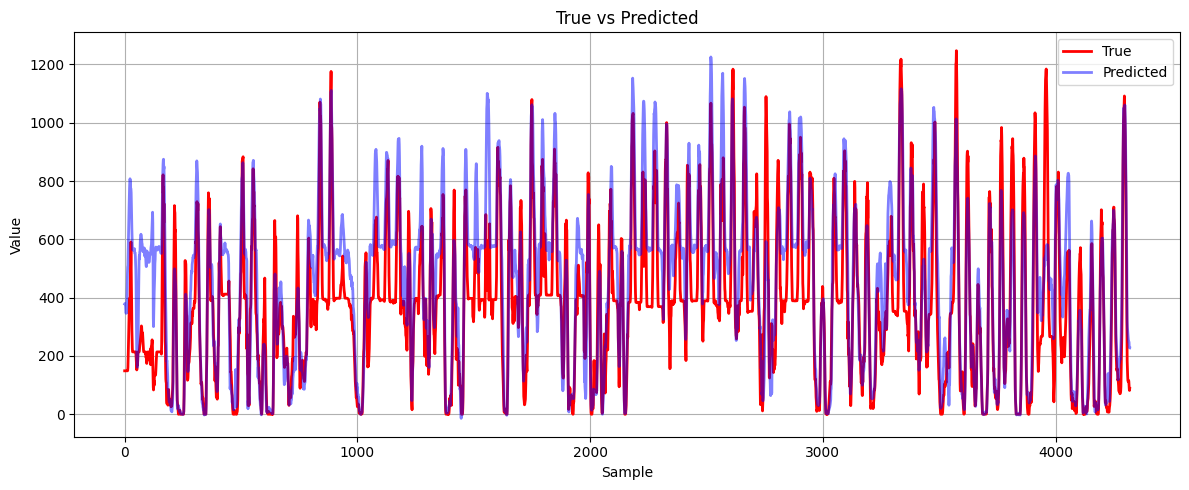

In [88]:
# Show output
plt.figure(figsize=(12, 5))
plt.plot(y_true_comp, label='True', linewidth=2,  color="red")
plt.plot(df_preds_new["q50"].values, label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Pinball score (REMI tot): 58.8378


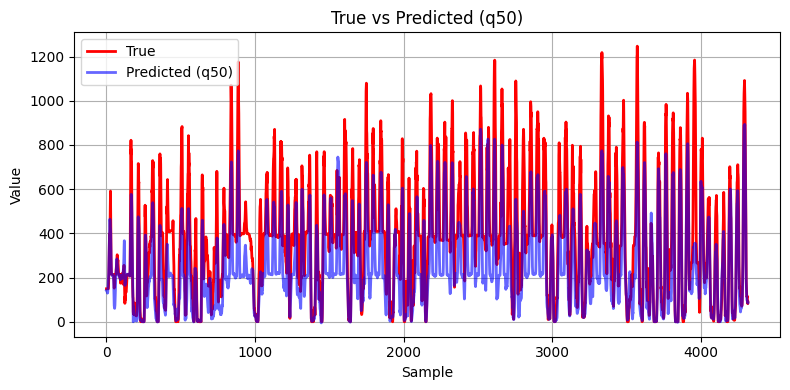

In [101]:
# Single run test of most resently run model with REMIT
# Import REMIT
df = pd.read_csv("data_comp/REMIT_capacity_comp.csv")
df["capacity_1_scaled"] = df["capacity_1"]/(400)
df["capacity_2_scaled"] = df["capacity_2"]/(400)
df["capacity_3_scaled"] = df["capacity_3"]/(400)
df["capacity_tot_scaled"] = df["capacity_tot"]/(1200)

# 1. Scale wind predictions per quantile
capacity_scaled = df["capacity_3_scaled"].to_numpy()  # shape (n_samples,)

y_p_wind_scaled = {
    q: wind_preds_new[q] * capacity_scaled
    for q in wind_preds_new
}

# 2. Combine with solar predictions
quant = sorted(wind_preds_new.keys())  # Ensure quantiles are ordered
y_p_comp_2 = np.column_stack([
    solar_preds_new[q] + y_p_wind_scaled[q]
    for q in quant
])

# 3. Create DataFrame for pinball score
df_preds_2 = pd.DataFrame(
    y_p_comp_2,
    columns=[f"q{int(q * 100)}" for q in quant]
)
df_preds_2["total_generation_MWh"] = y_true_comp

# 4. Calculate pinball score
score = pinball_score(df_preds_2)
print(f"Pinball score (REMI tot): {score:.4f}")

# 5. Plot true vs predicted (50th quantile)
plt.figure(figsize=(8, 4))
plt.plot(y_true_comp, label='True', linewidth=2, color="red")
plt.plot(df_preds_2["q50"].values, label='Predicted (q50)', linewidth=2, color="blue", alpha=0.6)

plt.title("True vs Predicted (q50)")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [93]:
display(wind_preds_new)
display(df["capacity_3_scaled"].to_numpy()[:, np.newaxis])

{0.1: array([256.89798, 255.4079 , 262.4078 , ..., 116.81038, 125.34968,
        126.05776], shape=(4320,), dtype=float32),
 0.2: array([322.30734, 324.23557, 301.1868 , ..., 151.92606, 153.9363 ,
        164.60614], shape=(4320,), dtype=float32),
 0.3: array([342.20303, 342.53076, 359.14996, ..., 187.40887, 186.11041,
        195.72333], shape=(4320,), dtype=float32),
 0.4: array([363.03784, 381.13513, 369.70898, ..., 220.4839 , 219.44153,
        214.77121], shape=(4320,), dtype=float32),
 0.5: array([378.1934 , 379.66965, 377.49646, ..., 228.86237, 227.81381,
        227.66354], shape=(4320,), dtype=float32),
 0.6: array([430.6747 , 419.0939 , 408.57486, ..., 244.70921, 240.23128,
        246.32352], shape=(4320,), dtype=float32),
 0.7: array([435.68546, 426.4361 , 420.89825, ..., 261.72897, 240.20656,
        244.13705], shape=(4320,), dtype=float32),
 0.8: array([453.07562, 456.7159 , 457.06857, ..., 289.18555, 272.88663,
        270.86182], shape=(4320,), dtype=float32),
 0.9: ar

array([[0.375],
       [0.375],
       [0.375],
       ...,
       [0.375],
       [0.375],
       [0.375]], shape=(5232, 1))